In [12]:
from joblib import dump
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('darkgrid')
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.model_selection import cross_val_predict
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVR

In [13]:
df = pd.read_csv('mm_data.csv')
Y = df['result_class']
X = df.drop(columns=['result_class','result_regr'])
X.shape

(1334, 35)

In [3]:
gbc = CalibratedClassifierCV(GradientBoostingClassifier(learning_rate=0.6, max_depth=1, n_estimators=12, random_state=321), 
                             method='sigmoid', cv=10)
gbc.fit(X, Y)
gbc_probs = gbc.predict_proba(X)

In [4]:
lrc = LogisticRegression(l1_ratio=0.5, C=0.15, fit_intercept=False, penalty='elasticnet', solver='saga', max_iter=1000, random_state=321)
cs_lrc = CalibratedClassifierCV(Pipeline(steps=[('center_scale', StandardScaler()), ('lrc', lrc)]),
                                method='sigmoid', cv=10)
cs_lrc.fit(X, Y)
cs_lrc_probs = cs_lrc.predict_proba(X)

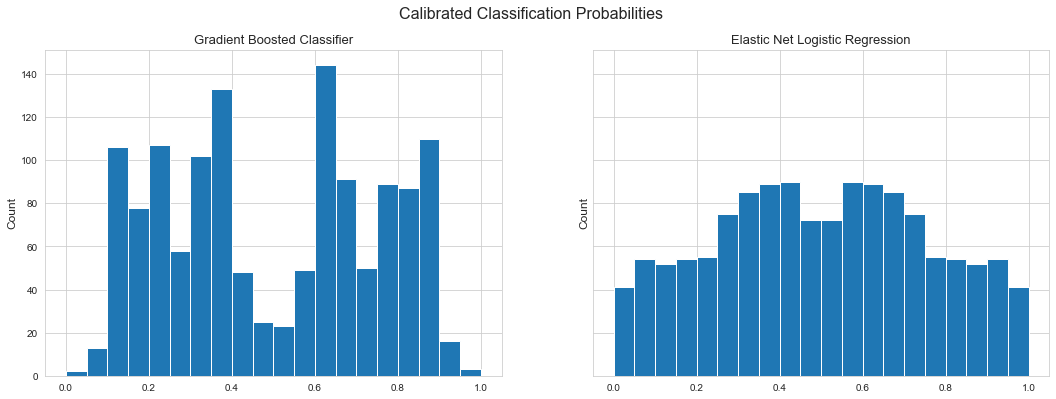

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(18,6))
fig.suptitle('Calibrated Classification Probabilities', size=16)
ax1.set_ylabel('Count', size=12)
ax1.set_title('Gradient Boosted Classifier', size=13)
_ = ax1.hist(gbc_probs[:,0], bins=20, range=(0,1))
ax2.set_ylabel('Count', size=12)
ax2.set_title('Elastic Net Logistic Regression', size=13)
_ = ax2.hist(cs_lrc_probs[:,0], bins=20, range=(0,1))

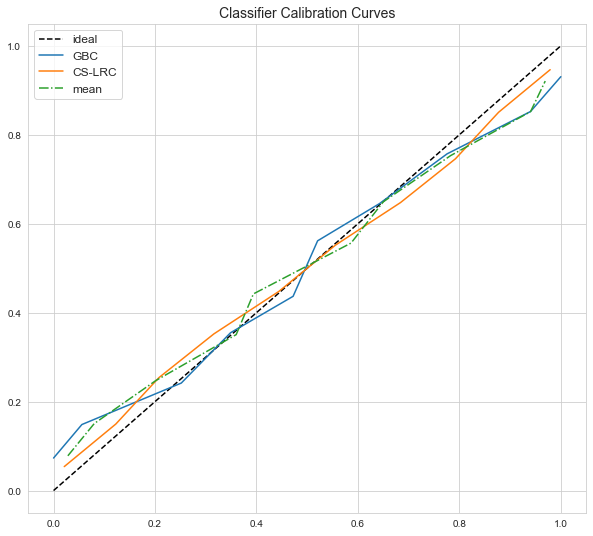

In [6]:
gbc_p_true, gbc_p_pred = calibration_curve(Y, gbc_probs[:,1], n_bins=10)
cs_lrc_p_true, cs_lrc_p_pred = calibration_curve(Y, cs_lrc_probs[:,1], n_bins=10)
mean_true, mean_pred = calibration_curve(Y, (gbc_probs[:,1] + cs_lrc_probs[:,1])/2, n_bins=10)

fig, ax = plt.subplots(1, 1, figsize = (10,9))
plt.title('Classifier Calibration Curves', size=14)
plt.plot([0,1], [0,1], 'k--', label='ideal')
plt.plot(gbc_p_true, gbc_p_pred, label='GBC')
plt.plot(cs_lrc_p_true, cs_lrc_p_pred, label='CS-LRC')
plt.plot(mean_true, mean_pred, '-.', label='mean')
plt.legend(prop={'size': 12})

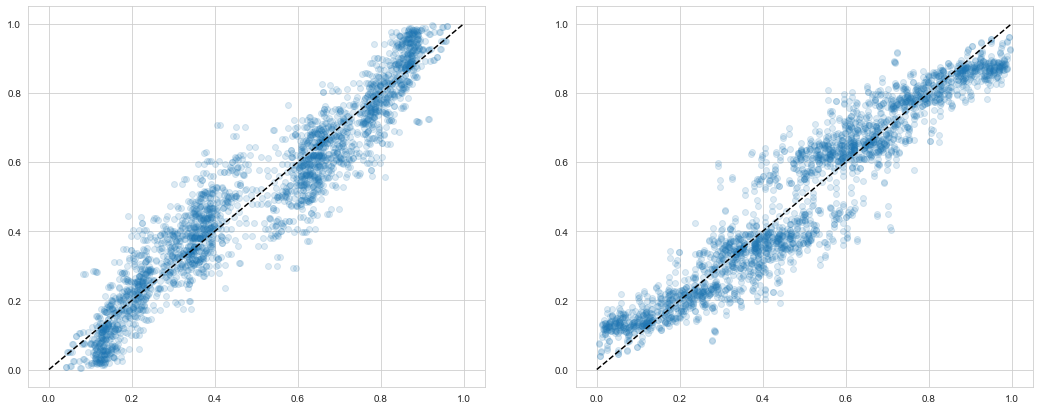

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.scatter(gbc_probs, cs_lrc_probs, alpha=0.15)
ax1.plot([0,1], [0,1], 'k--')
ax2.scatter(cs_lrc_probs, gbc_probs, alpha=0.15)
ax2.plot([0,1], [0,1], 'k--')

In [14]:
Y = df['result_regr']

In [15]:
pcr = Pipeline(steps=[('pca', PCA(svd_solver='full', whiten=True, n_components=0.96)), 
                      ('ols', LinearRegression(fit_intercept=False))])
pcr_preds = cross_val_predict(pcr, X, Y, cv=10)
pcr_resids = pcr_preds - Y
pcr.fit(X,Y)

Pipeline(steps=[('pca', PCA(n_components=0.96, svd_solver='full', whiten=True)),
                ('ols', LinearRegression(fit_intercept=False))])

In [16]:
pca_svm = Pipeline(steps=[('pca', PCA(svd_solver='full', whiten=True, n_components=0.99)), 
                      ('LinSVR', LinearSVR(C=0.003, fit_intercept=False, loss='squared_epsilon_insensitive', random_state=321))])
pca_svm_preds = cross_val_predict(pca_svm, X, Y, cv=10)
pca_svm_resids = pca_svm_preds - Y
pca_svm.fit(X,Y)

Pipeline(steps=[('pca', PCA(n_components=0.99, svd_solver='full', whiten=True)),
                ('LinSVR',
                 LinearSVR(C=0.003, fit_intercept=False,
                           loss='squared_epsilon_insensitive',
                           random_state=321))])

Text(0.5, 0, 'Predicted')

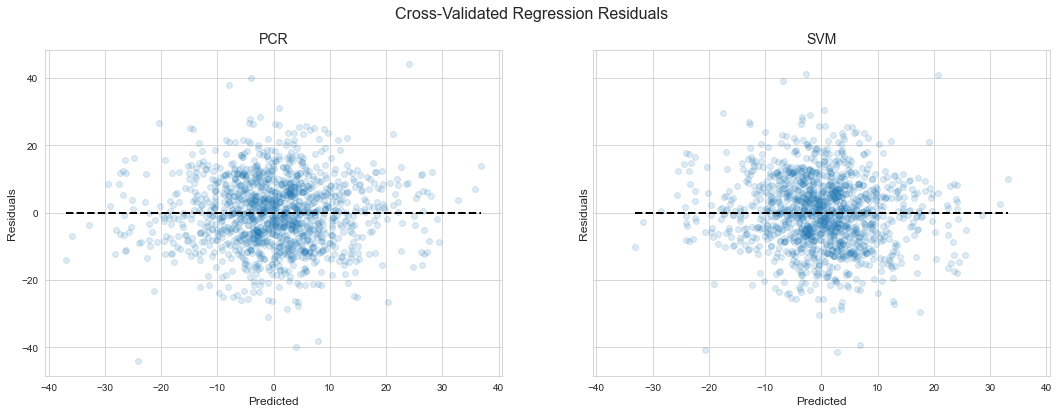

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(18,6))
fig.suptitle('Cross-Validated Regression Residuals', size=16)

ax1.scatter(pcr_preds, pcr_resids, alpha=0.15)
ax1.plot([pcr_preds.min(), pcr_preds.max()], [0, 0], 'k--', lw=2)
ax1.set_title('PCR', size=14)
ax1.set_ylabel('Residuals', size=12)
ax1.set_xlabel('Predicted', size=12)

ax2.scatter(pca_svm_preds, pca_svm_resids, alpha=0.15)
ax2.plot([pca_svm_preds.min(), pca_svm_preds.max()], [0, 0], 'k--', lw=2)
ax2.set_title('SVM', size=14)
ax2.set_ylabel('Residuals', size=12)
ax2.set_xlabel('Predicted', size=12)

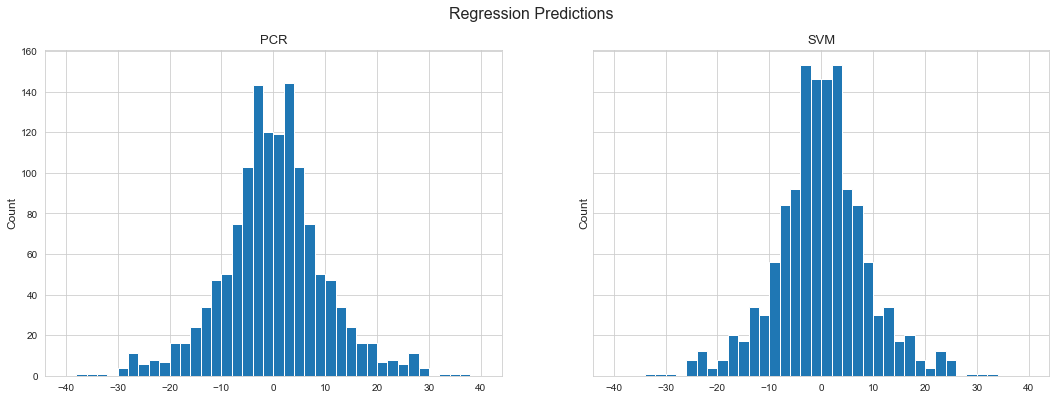

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(18,6))
fig.suptitle('Regression Predictions', size=16)
ax1.set_ylabel('Count', size=12)
ax1.set_title('PCR', size=13)
_ = ax1.hist(pcr_preds, bins=40, range=(-40,40))
ax2.set_ylabel('Count', size=12)
ax2.set_title('SVM', size=13)
_ = ax2.hist(pca_svm_preds, bins=40, range=(-40,40))

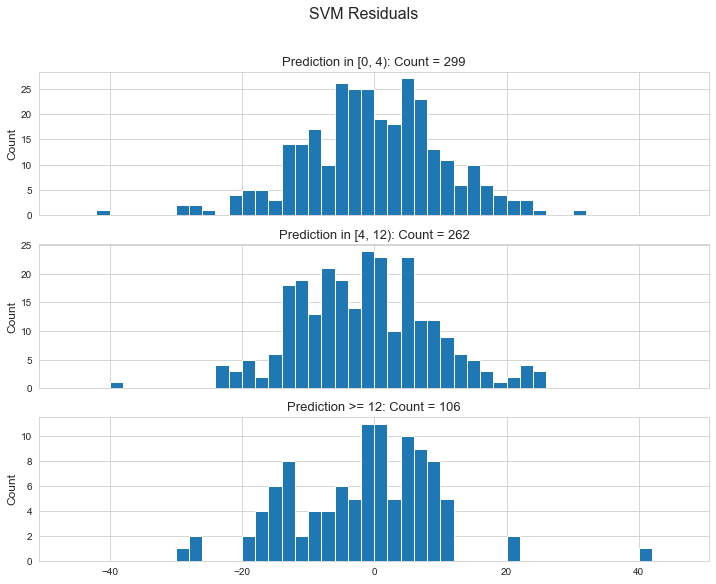

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,9))
fig.suptitle('SVM Residuals', size=16)

x = pd.Series(pca_svm_preds)
x = x.loc[(x>=0) & (x<4)] - Y.loc[(x>=0) & (x<4)]
ax1.set_ylabel('Count', size=12)
ax1.set_title('Prediction in [0, 4): Count = '+str(x.size), size=13)
_ = ax1.hist(x, bins=46, range=(-46,46))

x = pd.Series(pca_svm_preds)
x = x.loc[(x>=4) & (x<12)] - Y.loc[(x>=4) & (x<12)]
ax2.set_ylabel('Count', size=12)
ax2.set_title('Prediction in [4, 12): Count = '+str(x.size), size=13)
_ = ax2.hist(x, bins=46, range=(-46,46))

x = pd.Series(pca_svm_preds, name='preds')
x = x.loc[x >= 12] - Y.loc[x >= 12]
ax3.set_ylabel('Count', size=12)
ax3.set_title('Prediction >= 12: Count = '+str(x.size), size=13)
_ = ax3.hist(x, bins=46, range=(-46,46))


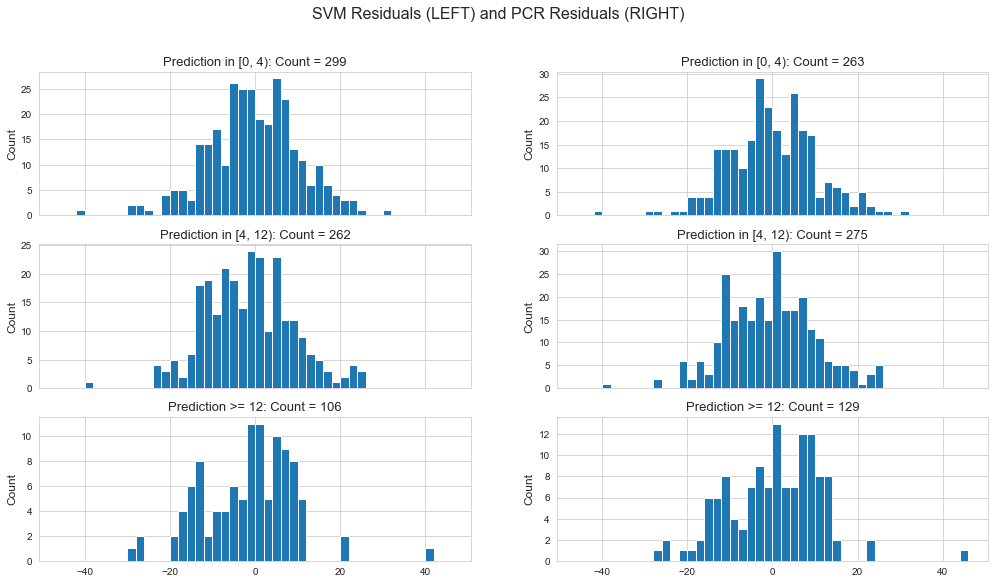

In [27]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(17,9))
fig.suptitle('SVM Residuals (LEFT) and PCR Residuals (RIGHT)', size=16)

x = pd.Series(pca_svm_preds)
x = x.loc[(x>=0) & (x<4)] - Y.loc[(x>=0) & (x<4)]
ax[0,0].set_ylabel('Count', size=12)
ax[0,0].set_title('Prediction in [0, 4): Count = '+str(x.size), size=13)
_ = ax[0,0].hist(x, bins=46, range=(-46,46))

x = pd.Series(pca_svm_preds)
x = x.loc[(x>=4) & (x<12)] - Y.loc[(x>=4) & (x<12)]
ax[1,0].set_ylabel('Count', size=12)
ax[1,0].set_title('Prediction in [4, 12): Count = '+str(x.size), size=13)
_ = ax[1,0].hist(x, bins=46, range=(-46,46))

x = pd.Series(pca_svm_preds, name='preds')
x = x.loc[x >= 12] - Y.loc[x >= 12]
ax[2,0].set_ylabel('Count', size=12)
ax[2,0].set_title('Prediction >= 12: Count = '+str(x.size), size=13)
_ = ax[2,0].hist(x, bins=46, range=(-46,46))

x = pd.Series(pcr_preds)
x = x.loc[(x>=0) & (x<4)] - Y.loc[(x>=0) & (x<4)]
ax[0,1].set_ylabel('Count', size=12)
ax[0,1].set_title('Prediction in [0, 4): Count = '+str(x.size), size=13)
_ = ax[0,1].hist(x, bins=46, range=(-46,46))

x = pd.Series(pcr_preds)
x = x.loc[(x>=4) & (x<12)] - Y.loc[(x>=4) & (x<12)]
ax[1,1].set_ylabel('Count', size=12)
ax[1,1].set_title('Prediction in [4, 12): Count = '+str(x.size), size=13)
_ = ax[1,1].hist(x, bins=46, range=(-46,46))

x = pd.Series(pcr_preds, name='preds')
x = x.loc[x >= 12] - Y.loc[x >= 12]
ax[2,1].set_ylabel('Count', size=12)
ax[2,1].set_title('Prediction >= 12: Count = '+str(x.size), size=13)
_ = ax[2,1].hist(x, bins=46, range=(-46,46))


### Save models to disk

In [14]:
dump(gbc, './pickle/gbc.joblib')
dump(cs_lrc, './pickle/cs_lrc.joblib')
dump(pca_svm, './pickle/pca_svm.joblib')

['pca_svm.joblib']

In [15]:
pca_svm_df = pd.DataFrame({'preds': pca_svm_preds, 'resids': pca_svm_resids})
dump(pca_svm_df, './pickle/pca_svm_df.joblib')

['pca_svm_df.joblib']

In [28]:
dump(pcr, './pickle/pcr.joblib')
pcr_df = pd.DataFrame({'preds': pcr_preds, 'resids': pcr_resids})
dump(pcr_df, './pickle/pcr_df.joblib')

['pcr_df.joblib']